<a href="https://colab.research.google.com/github/vpagonis/EURADOS-2023/blob/main/Code_5_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fitting multiple-peak TL data from unfaded samples using the KP-TL equation
In this section we analyze complex TL glow curves in feldspars, using the KPTL
equation. The analysis is based on the following physical assumptions:

(a) Each TL glow curve in a freshly irradiated sample consists of at least
5 constituent glow peaks, each corresponding to a di
erent activation energy
E. The E values are determined in a separate fractional glow experiment
(Pagonis et al. [117]). The donor-acceptor pairs for each trap are randomly distributed, and each trap in the unfaded sample is described by its own
nearest neighbor distribution.

(b) There are many more acceptors in the material than donors, so that
the material is characterized by a constant acceptor density parameter $\rho$.

Electrons from all 
ve traps are likely to be accessing the same recombination
center, and all traps are characterized by the same constant parameter $\rho'$.

The figure below the code  shows the results of CGCD analysis of the TL glow
curves for feldspar sample SAM3, based on the above assumptions. 

The result of the deconvolution of the complex TL glow curve is the sum of 5 individual peaks, located approximately at temperatures of 90, 150, 180, 250,
320$^{o}$C. The amplitudes A obtained from the least squares 
t procedure are $A=$2.2$\times10^{17}$, 5.2$\times10^{17}$, 3.4$\times10^{17}$,
1.8$\times10^{17}$, 4.1$\times10^{16}$ and the density parameter
$\rho'$=0.0064$\pm$0.0002.

For a Monte Carlo method of analyzing TL glow curves from feldspars
using a microscopic description of the tunneling process, the reader is referred
to Pagonis et al. [117].


+--------+--------+---------+
|  rho   |  drho  | FOM (%) |
+--------+--------+---------+
| 0.0064 | 0.0002 |   3.26  |
+--------+--------+---------+


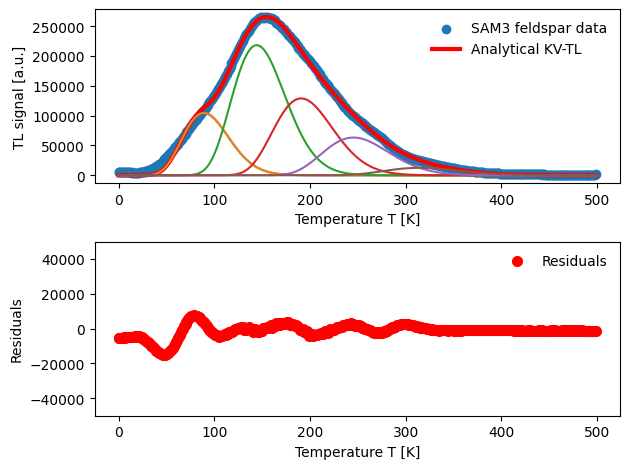

In [ ]:
#Deconvolution of 5-peak glow curve for SAM3 sample
# using the  KP-TL equation
from scipy import optimize
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from prettytable import PrettyTable 
import warnings
warnings.filterwarnings("ignore")
import requests

# read data file from GitHub
url='https://github.com/vpagonis/EURADOS-2023/raw/main/initialsensSAM3.TXT'

response = requests.get(url)
a = response.text
b = np.array(list(map(float,a.strip("[]").split())))
data = b.reshape(-1,2)

x_data, y_data = data[:, 0], data[:, 1]
kB=8.617E-5

# of peaks in TL signal
nPks=5

# constants
z,   kB,     s, =1.8, 8.617E-5,1e12

# Function for single KP-TL peak
def TL(T, B,En ,rho):
    return abs(B)* np.exp(-rho*( (np.log(1+z*s*kB*(((T+\
    273)**2.0)/np.abs(En))*np.exp(-En/(kB*(T+273)))*\
    (1-2*kB*(T+273)/En)))**3.0))*(En**2.0-6*(kB**2.0)*\
    ((T+273)**2.0))*((np.log(1+z*s*kB*(((T+273)**2.0)/\
    abs(En))*np.exp(-En/(kB*(T+273)))*(1-2*kB*(T+273)/\
    En)))**2.0)/(En*kB*s*((T+273)**2)*z-2*(kB**2.0)*\
    s*z*((T+273)**3.0)+np.exp(En/(kB*(T+273)))*En)

# Function to add several components
def total_TL(T, *inis): 
    u = np.array([0 for i in range(len(x_data))])
    Bs, rho=    inis[0:nPks],inis[-1]
    for i in range(nPks):
        u = u+TL(T,Bs[i],Ens[i],rho)
    return u

# initial values  for 5 peaks
inis = (5e16,9e16,10e16,1e16,.1e16,.004)
Ens = [.82, .95,1.06,1.19,1.355]

# find best fit and errors
params, cov = optimize.curve_fit(total_TL,\
x_data,y_data,p0=inis)

# plot data and best fit
plt.subplot(2,1, 1)
plt.scatter(x_data, y_data, label='SAM3 feldspar data')
plt.plot(x_data, total_TL(x_data, 
*params),c='r',linewidth=3, label='Analytical KV-TL')
plt.plot(x_data, TL(x_data, params[0],Ens[0],params[5]))
for i in range(0,nPks):
     plt.plot(x_data, TL(x_data, params[i],Ens[i],params[5]))
leg = plt.legend()
leg.get_frame().set_linewidth(0.0)
plt.ylabel('TL signal [a.u.]')
plt.xlabel(r'Temperature T [K]')

# plot residuals
plt.subplot(2,1, 2)
plt.scatter(x_data,total_TL(x_data, *params)
-y_data,c='r',linewidth=2,label='Residuals')
leg = plt.legend()
leg.get_frame().set_linewidth(0.0)
plt.ylabel('Residuals')
plt.xlabel(r'Temperature T [K]')
plt.ylim(-5e4,5e4)
plt.tight_layout()

# evaluate errors and FOM
res=total_TL(x_data, *params)-y_data
rho=round(params[5],4)
drho=round(np.sqrt(cov[5][5]),4)
FOM=round(100*np.sum(abs(res))/np.sum(y_data),2)

# print results in a Table
myTable = PrettyTable(["rho","drho","FOM (%)"])
myTable.add_row([rho,drho,FOM])
print(myTable)
plt.show()